In [1]:
# Vegetable Classification with the 'Vegetable' dataset expanded with extra images of broccoli, cauliflower, carrot and tomato from different datasets
# Transfer Learning with different base models and check the differences

In [3]:
import numpy as np 
import matplotlib.pyplot as plt

import os, warnings
warnings.filterwarnings("ignore")

import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix

from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3 
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dense, Dropout

K.clear_session()

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf

In [29]:
dataset = '../../dataset/'

train_folder = os.path.join(dataset,"train")
test_folder = os.path.join(dataset,"validation")
validation_folder = os.path.join(dataset,"test")

In [16]:
IMAGE_SIZE = [224, 224, 3]

inception = InceptionV3(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)

for layer in inception.layers:
    layer.trainable = False

x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

prediction = Dense(5, activation='softmax')(x)

model = Model(inputs=inception.input, outputs=prediction)

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [17]:
train_datagen = image.ImageDataGenerator(rescale = 1./255,
                                         shear_range = 0.2,
                                         zoom_range = 0.2,
                                         horizontal_flip = True)

test_datagen = image.ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(
    train_folder,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(
    test_folder, 
    target_size = (224, 224),
    batch_size = 32, 
    class_mode = 'categorical')

Found 5000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


In [18]:
class_map = training_set.class_indices
class_map

{'Bean': 0, 'Broccoli': 1, 'Carrot': 2, 'Cauliflower': 3, 'Tomato': 4}

In [19]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/5
157/157 [==============================] - 116s 723ms/step - loss: 0.0730 - accuracy: 0.9762 - val_loss: 0.0082 - val_accuracy: 0.9980
Epoch 2/5
157/157 [==============================] - 83s 526ms/step - loss: 0.0172 - accuracy: 0.9940 - val_loss: 0.0034 - val_accuracy: 0.9990
Epoch 3/5
157/157 [==============================] - 84s 537ms/step - loss: 0.0095 - accuracy: 0.9974 - val_loss: 0.0124 - val_accuracy: 0.9950
Epoch 4/5
157/157 [==============================] - 80s 512ms/step - loss: 0.0109 - accuracy: 0.9964 - val_loss: 0.0540 - val_accuracy: 0.9860
Epoch 5/5
157/157 [==============================] - 81s 515ms/step - loss: 0.0118 - accuracy: 0.9962 - val_loss: 3.5373e-04 - val_accuracy: 1.0000


In [22]:
model.save('model_inceptionV3_epoch5.h5')

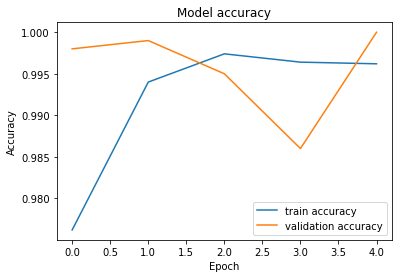

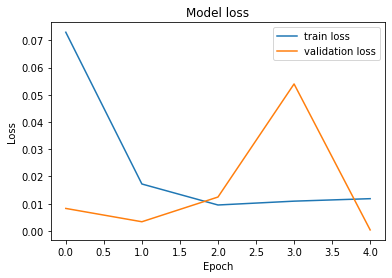

In [20]:
def plot_accuracy(history):
    
    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Accuracy_v1_InceptionV3')
    plt.show()
    
def plot_loss(history):
    
    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Loss_v1_InceptionV3')
    plt.show()
    
plot_accuracy(r)
plot_loss(r)

In [21]:
print("Total layers in the model : ",len(model.layers),"\n")

layers = [layer.output for layer in model.layers[0:]]
layer_names = []
for layer in model.layers[0:]: 
    layer_names.append(layer.name)
    
print("First layer : ", layer_names[0])
print("InceptionV3 layers : Layer 2 to Layer 311")
print("Our fine tuned layers : ", layer_names[311:314])
print("Final Layer : ", layer_names[314])

Total layers in the model :  315 

First layer :  input_2
InceptionV3 layers : Layer 2 to Layer 311
Our fine tuned layers :  ['global_average_pooling2d_1', 'dense_2', 'dropout_1']
Final Layer :  dense_3


In [23]:
K.clear_session()
path_to_model='./model_inceptionV3_epoch5.h5'
print("Loading the model..")
model = load_model(path_to_model)
print("Done!")

Loading the model..
Done!


In [25]:
validation_datagen = image.ImageDataGenerator(rescale=1. / 255)

validation_generator = validation_datagen.flow_from_directory(
    validation_folder,
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical')

scores = model.evaluate_generator(validation_generator)
print("Test Accuracy: {:.3f}".format(scores[1]))

Found 1000 images belonging to 5 classes.
Test Accuracy: 1.000


In [26]:
category={'Bean': 0, 'Broccoli': 1, 'Carrot': 2, 'Cauliflower': 3, 'Tomato': 4}

def predict_image(filename,model):
    img_ = image.load_img(filename, target_size=(224, 224))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0) 
    img_processed /= 255.   
    
    prediction = model.predict(img_processed)
    index = np.argmax(prediction)
    
    plt.title("Prediction - {}".format(category[index]))
    plt.imshow(img_array)
    
def predict_dir(filedir,model):
    cols=3
    pos=0
    images=[]
    total_images=len(os.listdir(filedir))
    rows=total_images//cols + 1
    
    true=filedir.split('/')[-1]
    
    for i in sorted(os.listdir(filedir)):
        images.append(os.path.join(filedir,i))
        
    for subplot, imggg in enumerate(images):
        img_ = image.load_img(imggg, target_size=(224, 224))
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0) 
        img_processed /= 255.
        prediction = model.predict(img_processed)
        index = np.argmax(prediction)
        
        pred=category.get(index)
        if pred==true:
            pos+=1

    acc=pos/total_images
    print("Accuracy for {orignal}: {:.2f} ({pos}/{total})".format(acc,pos=pos,total=total_images,orignal=true))